In [1]:
import os
import sys
import cv2
import random
import math
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.contrib import slim
print(tf.__version__)

from datasets import mnist
from datasets import dataset_utils
from models import lenet

/Users/jewatts/Library/Python/2.7/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.6.0-rc0


# Prepare Dataset

In [2]:
_RANDOM_SEED = 0
_NUM_VALIDATION = 6300

class ImageReader(object):
    def __init__(self):
        # Initializes function that decodes RGB JPEG data.
        self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
        self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)

    def read_image_dims(self, sess, image_data):
        image = self.decode_jpeg(sess, image_data)
        return image.shape[0], image.shape[1]

    def decode_jpeg(self, sess, image_data):
        image = sess.run(self._decode_jpeg,
                     feed_dict={self._decode_jpeg_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image

def _get_filenames_and_classes(dataset_dir):
    directories = []
    class_names = []
    for filename in os.listdir(dataset_dir):
        path = os.path.join(dataset_dir, filename)
        if os.path.isdir(path):
            directories.append(path)
            class_names.append(filename)

    photo_filenames = []
    for directory in directories:
        for filename in os.listdir(directory):
            path = os.path.join(directory, filename)
            photo_filenames.append(path)

    return photo_filenames, sorted(class_names)

def _dataset_exists(dataset_dir):
    for split_name in ['train', 'validation']:
        output_filename = _get_dataset_filename(dataset_dir, split_name)
        if not tf.gfile.Exists(output_filename):
            return False
    return True


def _get_dataset_filename(dataset_dir, split_name):
    output_filename = 'mnist_%s.tfrecord' % (split_name)
    return os.path.join(dataset_dir, output_filename)


def _convert_dataset(split_name, filenames, class_names_to_ids, dataset_dir):
    assert split_name in ['train', 'validation']

    with tf.Graph().as_default():
        image_reader = ImageReader()

        with tf.Session('') as sess:
            output_filename = _get_dataset_filename(dataset_dir, split_name)
            with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
                files_written=0
                for filename in filenames:
                    image_data = tf.gfile.FastGFile(filename, 'rb').read()
                    height, width = image_reader.read_image_dims(sess, image_data)

                    class_name = os.path.basename(os.path.dirname(filename))
                    class_id = class_names_to_ids[class_name]

                    example = dataset_utils.image_to_tfexample(image_data, b'jpg', height, width, class_id)
                    tfrecord_writer.write(example.SerializeToString())
                    files_written+=1
                print('%d files written for %s' % (files_written, split_name))
                    
def run(dataset_dir):
    if not tf.gfile.Exists(dataset_dir):
        tf.gfile.MakeDirs(dataset_dir)

    if _dataset_exists(dataset_dir):
        print('Dataset files already exist. Exiting without re-creating them.')
        return

    #dataset_utils.download_and_uncompress_tarball(_DATA_URL, dataset_dir)
    photo_filenames, class_names = _get_filenames_and_classes(dataset_dir)
    class_names_to_ids = dict(zip(class_names, range(len(class_names))))

    # Divide into train and test:
    random.seed(_RANDOM_SEED)
    random.shuffle(photo_filenames)
    training_filenames = photo_filenames[_NUM_VALIDATION:]
    validation_filenames = photo_filenames[:_NUM_VALIDATION]

    # First, convert the training and validation sets.
    _convert_dataset('train', training_filenames, class_names_to_ids,
                   dataset_dir)
    _convert_dataset('validation', validation_filenames, class_names_to_ids,
                   dataset_dir)

    # Finally, write the labels file:
    labels_to_class_names = dict(zip(range(len(class_names)), class_names))
    dataset_utils.write_label_file(labels_to_class_names, dataset_dir)
    return training_filenames, validation_filenames, class_names_to_ids

In [3]:
dataset_dir = "./data/mnist_as_jpeg/trainingSet"
training_filenames, validation_filenames, class_names_to_ids = run(dataset_dir)

35700 files written for train
6300 files written for validation


/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


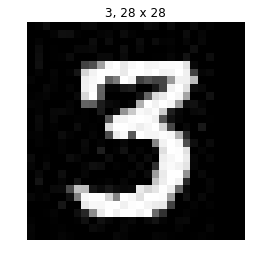

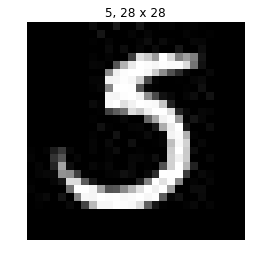

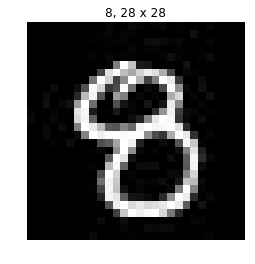

In [4]:
with tf.Graph().as_default(): 
    dataset = mnist.get_split('train', dataset_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)

    
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(3):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

# Train Network

In [5]:
def preprocess_image(image, output_height, output_width, is_training):
    image = tf.to_float(image)
    image = tf.image.resize_image_with_crop_or_pad(image, output_width, output_height)
    image = tf.subtract(image, 128.0)
    image = tf.div(image, 128.0)
    return image

def load_batch(dataset, batch_size=32, height=28, width=28, is_training=False):
    data_provider = slim.dataset_data_provider.DatasetDataProvider(dataset)

    image, label = data_provider.get(['image', 'label'])

    image = preprocess_image(image, height, width, is_training)

    images, labels = tf.train.batch(
        [image, label],
        batch_size=batch_size,
        allow_smaller_final_batch=True)

    return images, labels

def train(dataset_dir, batch_size, log_dir, num_steps):
    # load the dataset
    dataset = mnist.get_split('train', dataset_dir)

    # load batch of dataset
    images, labels = load_batch(dataset, batch_size, is_training=True)

    # run the image through the model
    logits, endpoints = lenet.lenet(images, num_classes=10, is_training=True,
          dropout_keep_prob=0.5)

    # get the cross-entropy loss
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()
    tf.summary.scalar('loss', total_loss)

    # use RMSProp to optimize
    optimizer = tf.train.RMSPropOptimizer(0.001, 0.9)

    # create train op
    train_op = slim.learning.create_train_op(total_loss, optimizer, summarize_gradients=True)

    # run training
    slim.learning.train(train_op, log_dir, save_summaries_secs=10, number_of_steps=num_steps)

In [6]:
num_steps = 1000
train(dataset_dir, 32, './output', num_steps)

/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/jewatts/Library/Python/2.7/lib/python/site-packa

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.


/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/jewatts/Library/Python/2.7/lib/python/site-packa

Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path ./output/model.ckpt
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 1: loss = 2.3462 (0.347 sec/step)
INFO:tensorflow:global step 2: loss = 2.4266 (0.101 sec/step)
INFO:tensorflow:Recording summary at step 2.
INFO:tensorflow:global step 3: loss = 2.4497 (0.066 sec/step)
INFO:tensorflow:global step 4: loss = 2.2841 (0.067 sec/step)
INFO:tensorflow:global step 5: loss = 2.3644 (0.060 sec/step)
INFO:tensorflow:global step 6: loss = 2.5189 (0.064 sec/step)
INFO:tensorflow:global step 7: loss = 2.2551 (0.054 sec/step)
INFO:tensorflow:global step 8: loss = 2.2651 (0.061 sec/step)
INFO:tensorflow:global step 9: loss = 2.3015 (0.080 sec/step)
INFO:tensorflow:global step 10: loss = 2.3384 (0.064 sec/step)
INFO:tens

INFO:tensorflow:global step 122: loss = 0.4756 (0.052 sec/step)
INFO:tensorflow:global step 123: loss = 0.3742 (0.050 sec/step)
INFO:tensorflow:global step 124: loss = 0.5960 (0.051 sec/step)
INFO:tensorflow:global step 125: loss = 0.2602 (0.050 sec/step)
INFO:tensorflow:global step 126: loss = 0.1466 (0.053 sec/step)
INFO:tensorflow:global step 127: loss = 0.2128 (0.053 sec/step)
INFO:tensorflow:global step 128: loss = 0.0957 (0.052 sec/step)
INFO:tensorflow:global step 129: loss = 0.2489 (0.049 sec/step)
INFO:tensorflow:global step 130: loss = 0.2418 (0.052 sec/step)
INFO:tensorflow:global step 131: loss = 0.1039 (0.051 sec/step)
INFO:tensorflow:global step 132: loss = 0.3651 (0.051 sec/step)
INFO:tensorflow:global step 133: loss = 0.3797 (0.050 sec/step)
INFO:tensorflow:global step 134: loss = 0.5667 (0.055 sec/step)
INFO:tensorflow:global step 135: loss = 0.1281 (0.051 sec/step)
INFO:tensorflow:global step 136: loss = 0.2705 (0.051 sec/step)
INFO:tensorflow:global step 137: loss = 

INFO:tensorflow:global step 249: loss = 0.1019 (0.054 sec/step)
INFO:tensorflow:global step 250: loss = 0.1282 (0.047 sec/step)
INFO:tensorflow:global step 251: loss = 0.1028 (0.048 sec/step)
INFO:tensorflow:global step 252: loss = 0.2109 (0.051 sec/step)
INFO:tensorflow:global step 253: loss = 0.3790 (0.051 sec/step)
INFO:tensorflow:global step 254: loss = 0.0847 (0.049 sec/step)
INFO:tensorflow:global step 255: loss = 0.0704 (0.047 sec/step)
INFO:tensorflow:global step 256: loss = 0.0293 (0.058 sec/step)
INFO:tensorflow:global step 257: loss = 0.0427 (0.054 sec/step)
INFO:tensorflow:global step 258: loss = 0.0282 (0.055 sec/step)
INFO:tensorflow:global step 259: loss = 0.0740 (0.058 sec/step)
INFO:tensorflow:global step 260: loss = 0.1699 (0.063 sec/step)
INFO:tensorflow:global step 261: loss = 0.1498 (0.062 sec/step)
INFO:tensorflow:global step 262: loss = 0.0485 (0.064 sec/step)
INFO:tensorflow:global step 263: loss = 0.1073 (0.080 sec/step)
INFO:tensorflow:global step 264: loss = 

INFO:tensorflow:global step 376: loss = 0.3601 (0.059 sec/step)
INFO:tensorflow:global step 377: loss = 0.0353 (0.063 sec/step)
INFO:tensorflow:global step 378: loss = 0.0437 (0.057 sec/step)
INFO:tensorflow:global step 379: loss = 0.2204 (0.059 sec/step)
INFO:tensorflow:global step 380: loss = 0.0232 (0.051 sec/step)
INFO:tensorflow:global step 381: loss = 0.1461 (0.053 sec/step)
INFO:tensorflow:global step 382: loss = 0.1370 (0.054 sec/step)
INFO:tensorflow:global step 383: loss = 0.1418 (0.053 sec/step)
INFO:tensorflow:global step 384: loss = 0.1551 (0.053 sec/step)
INFO:tensorflow:global step 385: loss = 0.2829 (0.055 sec/step)
INFO:tensorflow:global step 386: loss = 0.2312 (0.053 sec/step)
INFO:tensorflow:global step 387: loss = 0.0316 (0.056 sec/step)
INFO:tensorflow:global step 388: loss = 0.0106 (0.050 sec/step)
INFO:tensorflow:global step 389: loss = 0.0135 (0.057 sec/step)
INFO:tensorflow:global step 390: loss = 0.0279 (0.056 sec/step)
INFO:tensorflow:global step 391: loss = 

INFO:tensorflow:global step 505: loss = 0.0071 (0.054 sec/step)
INFO:tensorflow:global step 506: loss = 0.0348 (0.052 sec/step)
INFO:tensorflow:global step 507: loss = 0.1452 (0.051 sec/step)
INFO:tensorflow:global step 508: loss = 0.1465 (0.052 sec/step)
INFO:tensorflow:global step 509: loss = 0.1832 (0.052 sec/step)
INFO:tensorflow:global step 510: loss = 0.0950 (0.050 sec/step)
INFO:tensorflow:global step 511: loss = 0.1822 (0.051 sec/step)
INFO:tensorflow:global step 512: loss = 0.3085 (0.093 sec/step)
INFO:tensorflow:global_step/sec: 17.7942
INFO:tensorflow:global step 513: loss = 0.1628 (0.058 sec/step)
INFO:tensorflow:Recording summary at step 513.
INFO:tensorflow:global step 514: loss = 0.1299 (0.057 sec/step)
INFO:tensorflow:global step 515: loss = 0.0152 (0.050 sec/step)
INFO:tensorflow:global step 516: loss = 0.3112 (0.049 sec/step)
INFO:tensorflow:global step 517: loss = 0.0345 (0.052 sec/step)
INFO:tensorflow:global step 518: loss = 0.0587 (0.054 sec/step)
INFO:tensorflow:

INFO:tensorflow:global step 632: loss = 0.0776 (0.068 sec/step)
INFO:tensorflow:global step 633: loss = 0.0815 (0.065 sec/step)
INFO:tensorflow:global step 634: loss = 0.3072 (0.063 sec/step)
INFO:tensorflow:global step 635: loss = 0.3002 (0.065 sec/step)
INFO:tensorflow:global step 636: loss = 0.3204 (0.068 sec/step)
INFO:tensorflow:global step 637: loss = 0.0411 (0.065 sec/step)
INFO:tensorflow:global step 638: loss = 0.2167 (0.075 sec/step)
INFO:tensorflow:global step 639: loss = 0.0677 (0.074 sec/step)
INFO:tensorflow:global step 640: loss = 0.1849 (0.069 sec/step)
INFO:tensorflow:global step 641: loss = 0.0644 (0.067 sec/step)
INFO:tensorflow:global step 642: loss = 0.1927 (0.067 sec/step)
INFO:tensorflow:global step 643: loss = 0.0335 (0.066 sec/step)
INFO:tensorflow:global step 644: loss = 0.0487 (0.068 sec/step)
INFO:tensorflow:global step 645: loss = 0.0937 (0.066 sec/step)
INFO:tensorflow:global step 646: loss = 0.1441 (0.063 sec/step)
INFO:tensorflow:global step 647: loss = 

INFO:tensorflow:global step 759: loss = 0.0825 (0.055 sec/step)
INFO:tensorflow:global step 760: loss = 0.1027 (0.063 sec/step)
INFO:tensorflow:global step 761: loss = 0.0444 (0.055 sec/step)
INFO:tensorflow:global step 762: loss = 0.0067 (0.060 sec/step)
INFO:tensorflow:global step 763: loss = 0.0033 (0.055 sec/step)
INFO:tensorflow:global step 764: loss = 0.1120 (0.054 sec/step)
INFO:tensorflow:global step 765: loss = 0.0103 (0.057 sec/step)
INFO:tensorflow:global step 766: loss = 0.0442 (0.057 sec/step)
INFO:tensorflow:global step 767: loss = 0.0009 (0.057 sec/step)
INFO:tensorflow:global step 768: loss = 0.0017 (0.056 sec/step)
INFO:tensorflow:global step 769: loss = 0.0019 (0.071 sec/step)
INFO:tensorflow:global step 770: loss = 0.0511 (0.071 sec/step)
INFO:tensorflow:global step 771: loss = 0.0081 (0.067 sec/step)
INFO:tensorflow:global step 772: loss = 0.0128 (0.064 sec/step)
INFO:tensorflow:global step 773: loss = 0.0627 (0.099 sec/step)
INFO:tensorflow:global step 774: loss = 

INFO:tensorflow:global step 886: loss = 0.0151 (0.056 sec/step)
INFO:tensorflow:global step 887: loss = 0.0058 (0.054 sec/step)
INFO:tensorflow:global step 888: loss = 0.0023 (0.051 sec/step)
INFO:tensorflow:global step 889: loss = 0.0094 (0.048 sec/step)
INFO:tensorflow:global step 890: loss = 0.1109 (0.048 sec/step)
INFO:tensorflow:global step 891: loss = 0.4028 (0.051 sec/step)
INFO:tensorflow:global step 892: loss = 0.0015 (0.050 sec/step)
INFO:tensorflow:global step 893: loss = 0.0455 (0.051 sec/step)
INFO:tensorflow:global step 894: loss = 0.1117 (0.053 sec/step)
INFO:tensorflow:global step 895: loss = 0.1497 (0.053 sec/step)
INFO:tensorflow:global step 896: loss = 0.0190 (0.049 sec/step)
INFO:tensorflow:global step 897: loss = 0.1242 (0.046 sec/step)
INFO:tensorflow:global step 898: loss = 0.0091 (0.045 sec/step)
INFO:tensorflow:global step 899: loss = 0.0553 (0.047 sec/step)
INFO:tensorflow:global step 900: loss = 0.1743 (0.047 sec/step)
INFO:tensorflow:global step 901: loss = 

# Save to pb.

In [7]:
def freeze_graph(model_dir, output_node_names):
    """Extract the sub graph defined by the output nodes and convert 
    all its variables into constant 
    Args:
        model_dir: the root folder containing the checkpoint state file
        output_node_names: a string, containing all the output node's names, 
                            comma separated
    """
    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            "directory: %s" % model_dir)

    if not output_node_names:
        print("You need to supply the name of a node to --output_node_names.")
        return -1

    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path
    
    # We precise the file fullname of our freezed graph
    absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + "/frozen_model.pb"

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True

    # We start a session using a temporary fresh Graph
    with tf.Session(graph=tf.Graph()) as sess:
        # We import the meta graph in the current default Graph
        saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

        # We restore the weights
        saver.restore(sess, input_checkpoint)
        
        # We use a built-in TF helper to export variables to constants
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def(), # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))

    return output_graph_def

In [8]:
model_dir = './output'
output_node_names = 'Predictions/Softmax'
freeze_graph(model_dir, output_node_names)

/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/jewatts/Library/Python/2.7/lib/python/site-packa

INFO:tensorflow:Restoring parameters from ./output/model.ckpt-1000
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
55 ops in the final graph.


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Predict

In [9]:
MODEL_FILE = "./output/frozen_model.pb"

lenet_graph = tf.Graph()
with lenet_graph.as_default():
    lenet_graph_def = tf.GraphDef()
    with tf.gfile.GFile(MODEL_FILE, 'rb') as fid:
        serialized_graph = fid.read()
        lenet_graph_def.ParseFromString(serialized_graph)            
        tf.import_graph_def(lenet_graph_def, name='')
        
        sess = tf.Session()
        with sess.as_default():
            net = lambda img : sess.run(('Predictions/Softmax:0'), feed_dict={'batch:0':img})      

/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/Users/jewatts/Library/Python/2.7/lib/python/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)


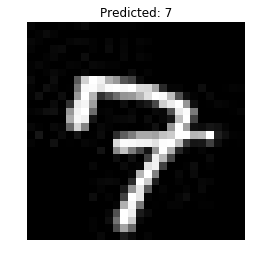

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [10]:
image = cv2.imread('./data/mnist_as_jpeg/testSet/img_6.jpg', 1)
image_data = np.expand_dims(image, axis=0)
predictions = net(image_data)
prediction = np.argmax(predictions)

# Plot Image
plt.figure()
plt.imshow(image)
plt.title('Predicted: %d' % (prediction))
plt.axis('off')
plt.show()

print(predictions)

In [11]:
total_validation = len(validation_filenames)
validationIx = 0

image_data = np.zeros((total_validation, 28, 28, 3))
image_class_ids = np.zeros(total_validation)

for filename in validation_filenames:
    image = cv2.imread(filename, 1)
    image_data[validationIx, :, :, :] = image

    class_name = os.path.basename(os.path.dirname(filename))
    image_class_ids[validationIx] = class_names_to_ids[class_name]

    validationIx += 1
    
predictions = net(image_data)
prediction = np.argmax(predictions, axis=1)

In [12]:
success = np.sum(prediction == image_class_ids)
accuracy = float(success) / float(prediction.shape[0])
print(success)
print(accuracy)

5872
0.932063492063


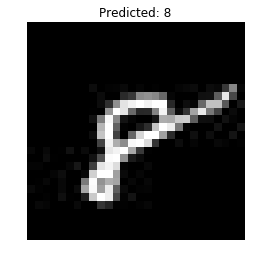

./data/mnist_as_jpeg/trainingSet/8/img_34603.jpg
8
8
8


In [13]:
test_file = validation_filenames[600]
test_image = cv2.imread(test_file, 1)
test_image_data = np.expand_dims(test_image, axis=0)
test_class_name = os.path.basename(os.path.dirname(test_file))
test_class_id = class_names_to_ids[test_class_name]

test_predictions = net(test_image_data)
test_prediction = np.argmax(test_predictions)

plt.figure()
plt.imshow(test_image)
plt.title('Predicted: %d' % (test_prediction))
plt.axis('off')
plt.show()

print(test_file)
print(test_class_name)
print(test_class_id)
print(test_prediction)